In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer, Adam
from tqdm import tqdm

from torchvision.datasets import DatasetFolder
from torchvision import transforms
from torchvision.datasets.folder import default_loader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Classes

In [3]:
class VaeEncoder(nn.Module):
    def __init__(self, image_width: int, latent_size: int, fourier_len: int = 0):
        super().__init__()
        self.image_width = image_width
        self.latent_size = latent_size

        transformed_width = image_width // 32

        self.encoder = nn.Sequential(
            nn.Conv2d(3 + fourier_len, 16, kernel_size=3, stride=1, padding=1), # image_width x image_width
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), # image_width x image_width
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # image_width/2 x image_width/2
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # image_width/2 x image_width/2
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # image_width/2 x image_width/2
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1), # image_width/4 x image_width/4
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), # image_width/4 x image_width/4
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # image_width/8 x image_width/8
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # image_width/8 x image_width/8
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1), # image_width/16 x image_width/16
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # image_width/16 x image_width/16
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1), # image_width/32 x image_width/32
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # image_width/32 x image_width/32
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # image_width/32 x image_width/32
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Flatten() # image_width/32 x image_width/32 x 128
        )

        self.mu = nn.Linear(transformed_width * transformed_width * 128, latent_size)
        self.logvar = nn.Linear(transformed_width * transformed_width * 128, latent_size)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

In [4]:
class VaeDecoder(nn.Module):
    def __init__(self, image_width: int, latent_size: int):
        super().__init__()
        self.image_width = image_width
        self.latent_size = latent_size

        transformed_width = image_width // 32

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, transformed_width * transformed_width * 128),
            nn.Unflatten(1, (128, transformed_width, transformed_width)),
            nn.ConvTranspose2d(128, 96, kernel_size=3, stride=2, padding=1, output_padding=1), # image_width/16 x image_width/16
            nn.LeakyReLU(),
            nn.BatchNorm2d(96),
            nn.ConvTranspose2d(96, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # image_width/8 x image_width/8
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # image_width/4 x image_width/4
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # image_width/2 x image_width/2
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # image_width x image_width
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, image_width: int):
        super().__init__()
        self.image_width = image_width

        image_width_transformed = image_width // 64

        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # image_width x image_width
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), # image_width x image_width
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2), # image_width/2 x image_width/2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # image_width/2 x image_width/2
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # image_width/2 x image_width/2
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2), # image_width/4 x image_width/4
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # image_width/4 x image_width/4
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2), # image_width/8 x image_width/8
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # image_width/8 x image_width/8
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2), # image_width/16 x image_width/16
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # image_width/16 x image_width/16
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2), # image_width/32 x image_width/32
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # image_width/32 x image_width/32
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2), # image_width/64 x image_width/64
            nn.Flatten(), # image_width/64 x image_width/64 x 128
            nn.Linear(image_width_transformed * image_width_transformed * 128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

In [6]:
def plot_random_image(decoder: nn.Module, latent_size: int):
    random_latent = torch.randn(1, latent_size).to(device)
    reconstruction = decoder(random_latent).detach().cpu().numpy()[0].transpose(1, 2, 0)

    plt.imshow(reconstruction)
    plt.axis('off')
    plt.show()

In [7]:
def plot_images(decoder: nn.Module, encoder: nn.Module, image: torch.Tensor):
    image_device = image.to(device)

    mu, logvar = encoder(image_device)
    var = torch.exp(logvar)
    std = torch.sqrt(var)
    epsilon = torch.randn_like(mu)
    latent = mu + std * epsilon

    reconstruction = decoder(latent).detach().cpu().numpy()

    image_plot = image.detach().cpu().numpy()[0][:3].transpose(1, 2, 0)
    reconstruction_plot = reconstruction[0].transpose(1, 2, 0)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image_plot)
    ax[0].axis('off')
    ax[1].imshow(reconstruction_plot)
    ax[1].axis('off')
    plt.show()

In [20]:
def train(encoder: nn.Module, decoder: nn.Module, discriminator: nn.Module,
          dataloader: DataLoader, epochs: int,
          encoder_optimizer: Optimizer, decoder_optimizer: Optimizer, discriminator_optimizer: Optimizer,
          img_width: int, vae_history: list[float] = [], discriminator_history: list[float] = []) -> list[float]:
    img_area = img_width * img_width

    MAX_DISCRIMINATOR_PART = 32
    MIN_DISCRIMINATOR_PART = 4
    discriminator_part = 8
    
    for i in range(epochs):
        total_loss_vae = 0
        total_loss_discriminator = 0
        total_mean_squared_error = 0
        total_accuracy = 0

        for j, (batch, _) in enumerate(tqdm(dataloader)):
            if j == 0:
                plot_images(decoder, encoder, batch[:1])

            if j % discriminator_part != 0:
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()

                batch_device = batch.to(device)

                mu, logvar = encoder(batch_device)
                var = torch.exp(logvar)
                epsilon = torch.randn_like(mu).to(device)
                z = mu + epsilon * torch.sqrt(var)

                reconstruction = decoder(z)
                grades = discriminator(reconstruction)
                ideal_grades = torch.clamp(torch.ones_like(grades) - torch.rand_like(grades) * 0.1, 0, 1).to(device)

                batch_images = batch_device[:, :3]
                
                reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, batch_images, reduction='sum')
                kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - var)
                grade_loss = nn.functional.binary_cross_entropy(grades, ideal_grades, reduction='sum')
                loss = reconstruction_loss + kl_divergence + grade_loss if j % 5 != 0 else grade_loss

                loss.backward()

                encoder_optimizer.step()
                decoder_optimizer.step()

                total_loss_vae += loss.item()

                total_mean_squared_error += (reconstruction - batch_images).pow(2).sum().item() / (img_area * batch_device.shape[0])
            else:
                discriminator_optimizer.zero_grad()

                batch_device = batch.to(device)
                random_latent = torch.randn(batch_device.shape[0], encoder.latent_size).to(device)

                real_images = batch_device[:, :3]
                fake_images = decoder(random_latent)

                real_grades = discriminator(real_images)
                fake_grades = discriminator(fake_images)

                real_ideal_grades = torch.clamp(torch.ones_like(real_grades) - torch.rand_like(real_grades) * 0.1, 0, 1).to(device)
                fake_ideal_grades = torch.clamp(torch.rand_like(fake_grades) * 0.1, 0, 1).to(device)

                real_loss = nn.functional.binary_cross_entropy(real_grades, real_ideal_grades, reduction='sum')
                fake_loss = nn.functional.binary_cross_entropy(fake_grades, fake_ideal_grades, reduction='sum')
                loss = real_loss + fake_loss

                loss.backward()

                discriminator_optimizer.step()

                accuracy = ((real_grades > 0.5).sum() + (fake_grades < 0.5).sum()).item() / (real_grades.shape[0] + fake_grades.shape[0])

                total_loss_discriminator += loss.item()
                total_accuracy += accuracy

        discriminator_count_ratio = 1 / discriminator_part

        data_len = len(dataloader)
        vae_len = np.ceil(data_len * (1 - discriminator_count_ratio))
        discriminator_len = np.ceil(data_len * discriminator_count_ratio)
        
        avg_loss_vae = total_loss_vae / vae_len
        avg_loss_discriminator = total_loss_discriminator / discriminator_len
        avg_accuracy = total_accuracy / discriminator_len
        avg_mean_squared_error = total_mean_squared_error / vae_len

        vae_history.append(avg_loss_vae)
        discriminator_history.append(avg_loss_discriminator)

        epoch_counter = i + 1
        real_epoch_counter = len(vae_history)

        if avg_accuracy > 0.8:
            discriminator_part = min(discriminator_part + 1, MAX_DISCRIMINATOR_PART)
        elif avg_accuracy < 0.6:
            discriminator_part = max(discriminator_part - 1, MIN_DISCRIMINATOR_PART)

        plot_random_image(decoder, encoder.latent_size)
        print(f'Epoch {epoch_counter} ({real_epoch_counter}) loss vae: {avg_loss_vae}, loss discriminator: {avg_loss_discriminator}, mean squared error: {avg_mean_squared_error}, accuracy: {avg_accuracy}')

    return vae_history, discriminator_history

In [9]:
class CachedImageFolder(DatasetFolder):
    def __compute_fourier_features(self):
        x = torch.linspace(0, 1, self.image_width) * 2 * np.pi
        y = torch.linspace(0, 1, self.image_width) * 2 * np.pi
        xx, yy = torch.meshgrid(x, y)

        for i in range(self.fourier_degree):
            for j in range(self.fourier_degree):
                freq_x = 2 ** i
                freq_y = 2 ** j

                self.fourier_features[2 * i] += torch.sin(freq_x * xx) * torch.sin(freq_y * yy)
                self.fourier_features[2 * i + 1] += torch.cos(freq_x * xx) * torch.cos(freq_y * yy)

    def __init__(self, root: str, transform: transforms.Compose, extensions: list[str], loader, image_width: int, fourier_degree: int = 0):
        super().__init__(root, loader, extensions=extensions)

        self.transform = transform
        self.to_tensor = transforms.ToTensor()
        self.cache = {}

        self.image_width = image_width

        self.fourier_degree = fourier_degree
        self.fourier_features = torch.zeros((2 * fourier_degree ** 2, image_width, image_width))

        if fourier_degree > 0:
            self.__compute_fourier_features()

    def __getitem__(self, index: int):
        item = self.cache[index] if index in self.cache else super().__getitem__(index)
        
        if index not in self.cache:
            self.cache[index] = item
        
        img, label = item
        img = self.transform(img)
        img = self.to_tensor(img)

        if self.fourier_degree > 0:
            img = torch.cat([img, self.fourier_features], dim=0)

        return img, label

# Objects

In [10]:
learning_rate = 5e-5
img_width = 256
latent_size = 512
fourier_degree = 5

In [11]:
fouriers_len = 2 * fourier_degree ** 2

In [12]:
decoder = VaeDecoder(img_width, latent_size).to(device)
encoder = VaeEncoder(img_width, latent_size, fouriers_len).to(device)
discriminator = Discriminator(img_width).to(device)

In [13]:
encoder_optimizer = Adam(encoder.parameters(), learning_rate)
decoder_optimizer = Adam(decoder.parameters(), learning_rate)
discriminator_optimizer = Adam(discriminator.parameters(), learning_rate * 0.5)

In [14]:
transform = transforms.Compose([
    transforms.RandomCrop((img_width, img_width))
])

In [15]:
def custom_loader(path) -> torch.Tensor:
    img = default_loader(path).convert('RGB')

    height, width = img.size
    min_dim = min(height, width)

    if min_dim < img_width:
        ratio = img_width / min_dim
        new_height = int(np.ceil(height * ratio))
        new_width = int(np.ceil(width * ratio))

        img = img.resize((new_height, new_width))

    return img

In [16]:
flowers_dataset = CachedImageFolder('flowers2', transform=transform, loader=custom_loader, extensions=('.jpg',), image_width=img_width, fourier_degree=fourier_degree)
flowers_dataloader = DataLoader(flowers_dataset, batch_size=16, shuffle=True)

c:\Python312\Lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


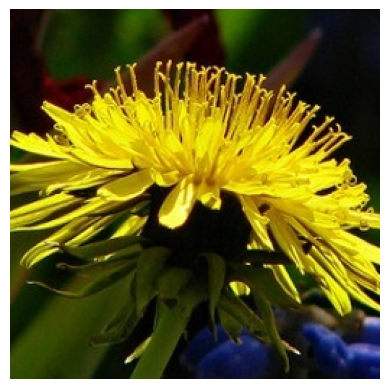

In [17]:
plt.imshow(next(iter(flowers_dataloader))[0][0][0:3, ...].permute(1, 2, 0))
plt.axis('off')
plt.show()

In [18]:
vae_history = []
discriminator_history = []

  0%|          | 0/230 [00:00<?, ?it/s]

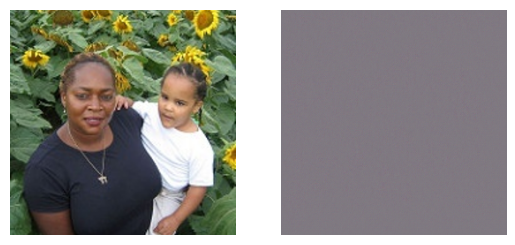

100%|██████████| 230/230 [01:05<00:00,  3.50it/s]


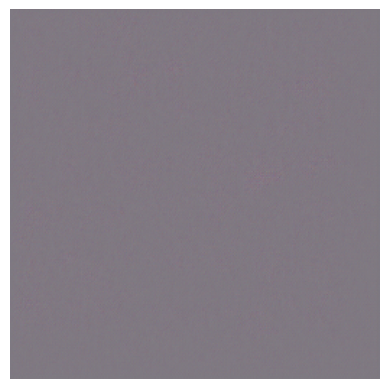

Epoch 1 (1) loss vae: 36.250430853059974, loss discriminator: 13.305146611970047, mean squared error: 0.28677231184031704, accuracy: 0.8523706896551724


  0%|          | 0/230 [00:00<?, ?it/s]

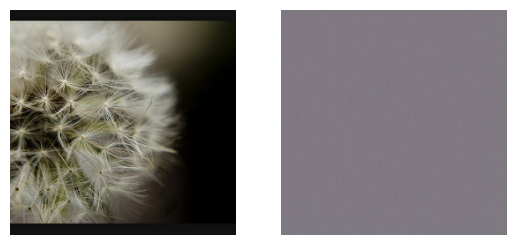

 68%|██████▊   | 156/230 [00:43<00:20,  3.62it/s]


KeyboardInterrupt: 

In [19]:
train(encoder, decoder, discriminator, flowers_dataloader, 200, encoder_optimizer, decoder_optimizer, discriminator_optimizer, img_width, vae_history, discriminator_history)

In [ ]:
plt.plot(vae_history)
plt.plot(discriminator_history)
plt.show()